## Описание проекта

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

**Наша задача** - построить модель, которая умеет определять рыночную стоимость автомобиля на вторичном рынке.  Для каждого автомобиля требуется предсказать числовое значение стоимости продажи.

В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Ход исследования:**

Данные для исследования мы получим из файлов, предоставленных заказчиком.

**Данные**   
train.csv - информация о характеристиках автомобилей, которые будут использоваться в качестве обучающих данных.   
test.csv - информация о характеристиках автомобилей, которые будут использоваться в качестве тестовых данных.    
vin - идентификатор автомобиля в тестовом наборе.   
sellingprice - Целевой признак.   

Наша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.

**Описание полей данных**

Date: Год выпуска автомобиля.   
Make: Марка автомобиля.   
Model: издание автомобиля определенной марки.   
Trim: Уровни отделки салона автомобиля — это просто разные версии модели.   
Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.   
Transmission: механизм, который передает мощность от двигателя к колесам.   
VIN: идентификационный номер транспортного средства.   
State: состояние, в котором автомобиль выставлен на аукцион.   
Condition: Состояние автомобилей на момент аукциона.     
Odometer: расстояние, пройденное автомобилем с момента выпуска.   
Color: Цвет кузова автомобиля.   
Interior: Цвет салона автомобиля.   
Seller: Продавец автомобиля, автосалоны.   
mmr: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.   
saledate: Дата продажи автомобиля.    

Целевой признак:

sellingprice: цена, по которой автомобиль был продан на аукционе.   

**Исследование пройдет в 7 этапов:**

* загрузка и первичное ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
разработка новых синтетических признаков,
проверка на мультиколлинеарность,
отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.
* общий вывод

## Загрузка и первичное ознакомление с данными

Импортируем необходимые для анализа данных библиотеки.

Считаем данные из csv-файла в датафрейм и сохраним в переменную data.

In [1]:
# импорт библиотек
#!pip install scikit-learn==1.1.3
#!pip install CatBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

import lightgbm

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


from catboost import CatBoostRegressor,cv
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### Первичный обзор данных

In [3]:
data = pd.read_csv('train.csv')

In [4]:
test = pd.read_csv('test.csv')

In [5]:
test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [6]:
# выберем стиль для оформления графиков
plt.style.use('fivethirtyeight')

In [7]:
print(f'Исходный датасет')
print(f'Количество строк {data.shape[0]}')
print(f'Количество столбцов {data.shape[1]}')

Исходный датасет
Количество строк 440236
Количество столбцов 15


In [8]:
print(f'Тестовый датасет')
print(f'Количество строк {test.shape[0]}')
print(f'Количество столбцов {test.shape[1]}')

Тестовый датасет
Количество строк 110058
Количество столбцов 14


In [9]:
# напишем функцию для вывода основной информации о датасете
def main_info(data):
    print(f'Выведем первые 5 строк датафрейма')
    display(data.head())
    print()

    print(f'Основная информация о датафрейме')
    print()
    display(data.info())
    print()

    print(f'Числовое описание данных')
    display(data.describe().style.background_gradient())
    print()

    print(f'Количество строк-дубликатов')
    display(data.duplicated().sum())
    print()

    print(f'Количество пропусков')
    display(pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient())
    print()

    print(f'Тип признаков')
    print(data.dtypes)

In [10]:
# посмотрим обучающий датасет
main_info(data)

Выведем первые 5 строк датафрейма


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


None


Числовое описание данных


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000



Количество строк-дубликатов


0


Количество пропусков


,0
year,0.000000
make,1.800000
model,1.800000
trim,1.900000
body,2.400000
transmission,11.700000
vin,0.000000
state,0.000000
condition,2.100000
odometer,0.000000



Тип признаков
year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
sellingprice      int64
saledate         object
dtype: object


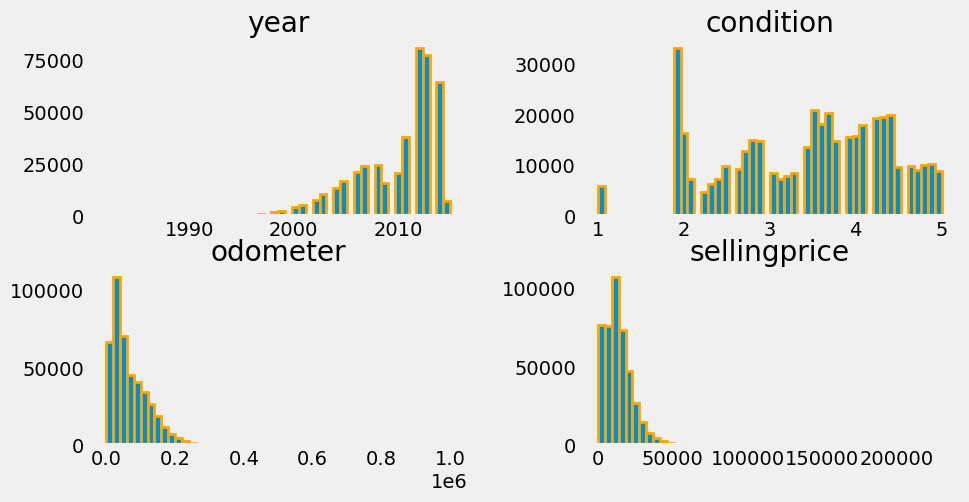

In [11]:
data.hist(bins=50, figsize=(10,5), edgecolor='orange', grid=False, linewidth=2)
plt.show()

In [12]:
# изучим тестовые данные
main_info(test)

Выведем первые 5 строк датафрейма


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)



Основная информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


None


Числовое описание данных


,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000



Количество строк-дубликатов


0


Количество пропусков


,0
year,0.000000
make,1.900000
model,1.900000
trim,1.900000
body,2.400000
transmission,11.800000
vin,0.000000
state,0.000000
condition,2.200000
odometer,0.000000



Тип признаков
year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
saledate         object
dtype: object


Вывод после первичного обзора и загрузки обучающих и тестовых данных:

* обучающий датасет содержит 440236 объектов и 15 столбцов(признаков);   
* названия колонок почти соответствуют первоначальному описанию данных (столбец date назван уеаг, столбец mmr отсутствует);   
* типы данных: 4 столбцов это численные признаки(int64,float64) и 11 столбцов это категориальные(object);   
* в данных обнаружены пропуски:11.7% столбец transmission, 2.4% - body, 2.1% - condition, и около 1.8-1.9% - make,model,trim(обработаем позднее);   
* строки с явными дубликатами отсутствуют;      
* из описания данных видно, что все столбцы достаточно информативны и будут полезны для предсказания стоимости;

* целевой признак в столбце sellingprice.

В некоторых столбцах трейна (например,saledate) требуется поменять тип данных, а также в тесте в столбцах condition и    odometer (с float64 на float).


В тестовых данных мы имеем 110058 объектов и 14 столбцов(отсутствует целевой признак, который будем предсказывать). В остальном те же характеристики, что и в обучающем наборе данных.

Перед нами стоит задача регрессии. 

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,440236.0,2010.040101,3.977945,1982.0,2007.0,2012.0,2013.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


Годы выпуска автомобилей находятся в промежутке с 1982 по 2015 гг.    
Состояние авто оценивается в среднем на 3,4. Максимальная оценка 5.   
Средний пробег автомобилей составляет 68344,42 км. При этом максимальный пробег 999999,0 км.   
Средняя цена продажи составила 13592 ед. При этом максимум составил 230000,0 ед.   

### Проведем более детальную предобработку наших признаков

**Поменяем тип данных в дате продажи**

In [14]:
# переведем столбец к типу данных datetime, с учетом временной зоны UTC
data['saledate']=pd.to_datetime(data['saledate'],utc=True)

data['saledate']

0        2015-06-01 19:30:00+00:00
1        2015-02-24 18:00:00+00:00
2        2015-06-09 19:30:00+00:00
3        2015-06-16 20:00:00+00:00
4        2015-02-02 20:00:00+00:00
                    ...           
440231   2015-01-19 20:30:00+00:00
440232   2015-02-10 18:00:00+00:00
440233   2015-03-02 20:30:00+00:00
440234   2015-01-13 18:05:00+00:00
440235   2015-01-14 18:00:00+00:00
Name: saledate, Length: 440236, dtype: datetime64[ns, UTC]

In [15]:
test['saledate']=pd.to_datetime(test['saledate'],utc=True)

In [16]:
# посмотрим период за который у нас есть данные в обучающей выборке
max_date = data['saledate'].max()
min_date = data['saledate'].min()
print(f'Обучающие данные представлены за период c {min_date} по {max_date}')

Обучающие данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00


In [17]:
# посмотрим период за который у нас есть данные в тестовой выборке
max_tdate = test['saledate'].max()
min_tdate = test['saledate'].min()
print(f'Тестовые данные представлены за период c {min_tdate} по {max_tdate}')

Тестовые данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00


In [18]:
# получаем информацию о годах продажи
data['saledate'].dt.year.sort_values().unique()


array([2014, 2015], dtype=int64)

In [19]:
# получаем информацию о месяцах продажи
data['saledate'].dt.month.sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7, 12], dtype=int64)

Нет продаж с августа по декабрь.

In [20]:
# получаем информацию о дне недели
data['saledate'].dt.weekday.sort_values().unique()


array([0, 1, 2, 3, 4, 6], dtype=int64)

Машины продавались с понедельника по субботу.

**Проведем работу с пропусками в данных**

In [21]:
# посмотрим подробно пропуски в 'transmission'
data[data['transmission'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
13,2006,Chevrolet,Silverado 1500,LS,Extended Cab,NaN,1gcek19bx6z269153,tx,2.2,166999.0,white,gray,texas direct auto,6700,2015-02-24 18:20:00+00:00
27,2014,Dodge,Charger,SXT,Sedan,NaN,2c3cdxhg0eh267271,va,4.0,21631.0,blue,black,hertz corporation/gdp,18100,2015-02-11 16:45:00+00:00
31,2012,Mercedes-Benz,GL-Class,GL450 4MATIC,SUV,NaN,4jgbf7be8ca797360,ga,4.1,55612.0,white,brown,mercedes-benz finc wholesale advantage,30750,2015-02-03 18:00:00+00:00
49,2007,Chevrolet,Silverado 1500,LTZ,Crew Cab,NaN,2gcek13m171647736,ga,2.2,108799.0,blue,—,td auto finance,15200,2015-01-08 02:00:00+00:00
53,2013,Ford,Mustang,V6,Convertible,NaN,1zvbp8em0d5237253,pa,3.5,67478.0,blue,black,northeast leasing,11600,2015-03-12 19:00:00+00:00


In [22]:
# посмотрим подробно пропуски в 'transmission' в тесте
test[test['transmission'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-26 17:00:00+00:00
19,2014,Chevrolet,Silverado 1500,LT,crew cab,NaN,3gcukrec4eg454516,pa,4.9,26294.0,red,black,enterprise veh exchange/rental,2015-07-13 23:30:00+00:00
24,2014,Ford,E-Series Wagon,E-350 Super Duty XLT,van,NaN,1fbne3bl1eda46070,ny,3.3,33020.0,white,gray,ford motor credit company,2015-06-02 19:20:00+00:00
53,2013,Honda,CR-V,EX-L,SUV,NaN,5j6rm3h7xdl004568,ga,3.9,30686.0,blue,gray,wells fargo dealer services,2015-01-21 18:00:00+00:00
54,2010,Audi,A6,3.0T Premium quattro,Sedan,NaN,waufgafb8an026867,pa,4.6,74911.0,blue,black,adcock brothers inc,2015-02-20 01:00:00+00:00


In [23]:
# посмотрим подробно пропуски в столбце 'make'
data[data['make'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,2015-01-28 19:30:00+00:00
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,2015-06-15 19:30:00+00:00
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,2015-06-03 20:00:00+00:00
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,2015-02-04 20:00:00+00:00
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,2015-02-04 20:00:00+00:00


In [24]:
# посмотрим подробно пропуски в столбце 'make' в тесте
test[test['make'].isnull()].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,2015-01-22 17:00:00+00:00
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,2014-12-22 03:00:00+00:00
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,2015-02-17 18:00:00+00:00
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,2015-02-18 19:00:00+00:00
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,2015-02-23 17:30:00+00:00


Пропуски также обнаружены и в соседних столбцах.

In [25]:
# установим библиотеку для Vin и получим из нее информацию по марке авто
!pip install vininfo[cli]

In [26]:
from vininfo import Vin

# напишем функцию для замены пропуенных значений в столбце 'make'
def fill_car_details(row):
    # получим значения VIN из столбца 'vin'
    vin_number = row['vin']

    vin = Vin(vin_number)

    # заполним значений столбцов 'make' из VIN
    row['make'] = vin.manufacturer

    return row

# примененим функцию fill_car_details к каждой строке DataFrame
data = data.apply(fill_car_details, axis=1)

# посмотрим подробно пропуски в столбце 'make'
data['make'].isnull().sum()

0

In [27]:
# примененим функцию fill_car_details к каждой строке теста DataFrame
test = test.apply(fill_car_details, axis=1)

# посмотрим подробно пропуски в столбце 'make'
test['make'].isnull().sum()

0

In [28]:
# сгруппируем данные и посмотрим уровень значимости каждого значения 'transmission' в каждой группе как доля от общего количества записей 'transmission'
grouped_data = data.groupby(['year','make', 'model'])['transmission'].value_counts(1)
grouped_data

year  make           model     transmission
1984  Chevrolet      corvette  automatic       1.0
1985  Chevrolet      corvette  automatic       0.5
                               manual          0.5
1986  Chevrolet      corvette  manual          1.0
      Mercedes-Benz  420sel    automatic       1.0
                                              ... 
2015  Volvo Cars     S60       automatic       1.0
                     S80       automatic       1.0
                     V60       automatic       1.0
                     XC60      automatic       1.0
                     XC70      automatic       1.0
Name: transmission, Length: 7074, dtype: float64

In [29]:
# напишем функцию для замены пропущенных значений в столбце 'transmission' c помощью метода idxmax, который возвращает индекс элемента с наибольшим значением
def fill_transmission(row):
    if pd.isnull(row['transmission']):
        year = row['year']
        make = row['make']
        model = row['model']
        if (year,make, model) in grouped_data.index:
            probabilities = grouped_data.loc[(year,make, model)]
            most_probable_transmission = probabilities.idxmax()
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']
# заполним пропущенные значения в столбце 'transmission'
data['transmission'] = data.apply(fill_transmission, axis=1)

In [30]:
data['transmission'].isnull().sum()

1574

In [31]:
pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient()

,0
year,0.000000
make,0.000000
model,1.850000
trim,1.890000
body,2.360000
transmission,0.360000
vin,0.000000
state,0.000000
condition,2.140000
odometer,0.020000


In [32]:
# заполним аналогично пропуски в трансмиссии в тесте
grouped_test = test.groupby(['year','make', 'model'])['transmission'].value_counts(1)

In [33]:
# напишем функцию для замены пропущенных значений в столбце 'transmission' в тесте
def fill_transmission_t(row):
    if pd.isnull(row['transmission']):
        year = row['year']
        make = row['make']
        model = row['model']
        if (year,make, model) in grouped_test.index:
            probabilities_t = grouped_test.loc[(year,make, model)]
            most_probable_transmission = probabilities_t.idxmax()
            return most_probable_transmission
        else:
            return np.nan
    else:
        return row['transmission']

# заполним пропущенные значения в столбце 'transmission'
test['transmission'] = test.apply(fill_transmission_t, axis=1)

In [34]:
test['transmission'].isnull().sum()

472

Большую часть пропусков в столбце 'transmission' удалось заполнить. Осталось всего 0,4%. На трейне оставшиеся пропуски удалим.

На тесте заменим пропуски в оставшихся столбцах значением 'no'.

In [35]:
# удалим строки с пропущенными значениями

data = data.dropna(subset=['model','trim','body','transmission','odometer','condition','color','interior']).reset_index(drop=True)
# проверим остались ли пропуски
data.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [36]:
# посмотрим оставшиеся пропуски в тесте
pd.DataFrame(round(test.isna().mean()*100,2)).style.background_gradient()

,0
year,0.000000
make,0.000000
model,1.890000
trim,1.920000
body,2.360000
transmission,0.430000
vin,0.000000
state,0.000000
condition,2.160000
odometer,0.020000


In [37]:
# посмотрим типы данных в тесте
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          110058 non-null  int64              
 1   make          110058 non-null  object             
 2   model         107979 non-null  object             
 3   trim          107944 non-null  object             
 4   body          107464 non-null  object             
 5   transmission  109586 non-null  object             
 6   vin           110058 non-null  object             
 7   state         110058 non-null  object             
 8   condition     107679 non-null  float64            
 9   odometer      110039 non-null  float64            
 10  color         109900 non-null  object             
 11  interior      109900 non-null  object             
 12  seller        110058 non-null  object             
 13  saledate      110058 non-null  datetime64[ns

In [38]:
# изменим тип данных
test['odometer'] = test['odometer'].astype(float)
test['condition'] = test['condition'].astype(float)

In [39]:
test['condition'].fillna(0, inplace=True)
test['odometer'].fillna(0, inplace=True)

In [40]:
# оставшиеся пропуски заменим во всех столбцах
test = test.fillna('no')

In [41]:
# проверим
test.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
dtype: int64

In [42]:
# проверим размер
test.shape

(110058, 14)

Пропуски обработаны.

**Рассмотрим неявные дубликаты**

In [43]:
# посмотрим уникальные значения марок авто
data['make'].unique()

array(['Ford', 'Nissan', 'Hummer', 'Lincoln', 'Genesis', 'Buick',
       'Chevrolet', 'Chevrolet Canada', 'Honda', 'Acura', 'Cadillac',
       'GMC', 'Saab', 'Chrysler', 'Mercedes-Benz', 'Toyota',
       'Chevrolet USA', 'Volkswagen', 'BMW',
       'Auto Alliance International', 'Hyundai', 'Kia', 'Jaguar',
       'Subaru', 'Chrysler Canada', 'DaimlerChrysler AG/Daimler AG',
       'Dodge', 'Lexus', 'Jeep', 'Scion', 'Fiat', 'Chevrolet Mexico',
       'Lexus Canada', 'Dodge Canada', 'Mazda', 'Volvo Cars', 'Audi',
       'NUMMI', 'BMW M', 'Infiniti', 'Mini', 'Isuzu', 'GMC Truck', 'CAMI',
       'Mitsubishi', 'Smart', 'Pontiac', 'Dodge Mexico', 'Porsche car',
       'General Motors', 'Land Rover', 'Suzuki', 'Ford Otosan', 'Saturn',
       'Ram', 'Honda Mexico', 'Oldsmobile', 'Toyota Mexico', 'Mercury',
       'Bentley', 'Mitsubishi Thailand', 'Mercury Mexico', 'Porsche SUV',
       'Daimler AG (Sprinter)', 'Fisker', 'Suzuki Canada', 'Maserati',
       'Quattro', 'Mercedes-Benz (Sprinter)',

In [44]:
test['make'].unique()

array(['Cadillac', 'GMC Truck', 'Nissan', 'Chevrolet', 'Volkswagen',
       'Hyundai', 'Ford', 'Chevrolet Mexico', 'Subaru', 'Kia', 'BMW',
       'Chevrolet USA', 'Genesis', 'Chevrolet Canada', 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo Cars', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'GMC', 'Audi', 'Lincoln', 'Ford Otosan', 'Infiniti',
       'Jeep', 'Chrysler Canada', 'DaimlerChrysler AG/Daimler AG',
       'Chrysler', 'Ram', 'Scion', 'Dodge Canada', 'Dodge Mexico',
       'Mercury', 'Lexus Canada', 'Lexus', 'Saturn', 'Mazda',
       'Mercedes-Benz', 'Porsche car', 'NUMMI',
       'Auto Alliance International', 'Mini', 'Smart', 'Land Rover',
       'Buick', 'Toyota Mexico', 'BMW M', 'Hummer', 'Jaguar', 'Fiat',
       'Mitsubishi Thailand', 'CAMI', 'Porsche SUV', 'Saab',
       'General Motors', 'Mercury Mexico', 'Suzuki', 'Suzuki Canada',
       'Quattro', 'Bentley', 'Honda Mexico', 'Mercedes-Benz (Sprinter)',
       'Isuzu', 'Aston Martin Lagonda Limited', 'Daimler AG (S

In [45]:
# посчитаем количество уникальных значений в столбце 'make' тренировочного датасета
print(data['make'].nunique())
print(test['make'].nunique())

81
80


In [46]:
# приведем значения к нижнему регистру
data['make'] = data['make'].str.lower()

test['make'] = test['make'].str.lower()

In [47]:
# посмотрим результат
print(data['make'].nunique())
print(test['make'].nunique())

81
80


Ничего не изменилось.

In [48]:
# посмотрим уникальные значения в столбце 'body'
data['body'].unique()

array(['suv', 'Sedan', 'sedan', 'SUV', 'wagon', 'Minivan', 'Extended Cab',
       'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon', 'convertible',
       'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback', 'minivan',
       'hatchback', 'G Coupe', 'G Convertible', 'coupe', 'Access Cab',
       'G Sedan', 'regular cab', 'e-series van', 'supercrew', 'Quad Cab',
       'tsx sport wagon', 'Van', 'g sedan', 'E-Series Van', 'CTS Coupe',
       'Koup', 'King Cab', 'extended cab', 'double cab', 'Elantra Coupe',
       'koup', 'access cab', 'Double Cab', 'crew cab', 'quad cab',
       'g coupe', 'CrewMax Cab', 'supercab', 'g convertible',
       'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van', 'Q6

In [49]:
# проверим количество уникальные значения в столбце 'body'
print(data['body'].nunique())
print(test['body'].nunique())


85
78


In [50]:
# приведем значения к нижнему регистру и проверим оставшееся количество
data['body'] = data['body'].str.lower()
test['body'] = test['body'].str.lower()

In [51]:
print(data['body'].nunique())
print(test['body'].nunique())


45
43


Удалось снизить количество дубликатов.

In [52]:
# посмотрим уровни отделки салона
data['trim'].unique()

array(['SEL', 'SE', '2.0 SL', ..., '2.0 TDI Premium Plus',
       '2.5 X L.L.Bean Edition', '3500 High Roof 140 WB'], dtype=object)

Очень много разнообразных значений, оставим все как есть.

In [53]:
# посмотрим варианты цветов салона
data['interior'].unique()


array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', 'blue',
       'white', 'silver', 'red', 'green', 'gold', 'purple', 'orange',
       'burgundy', 'yellow'], dtype=object)

In [54]:
# цвета кузова
data['color'].unique()

array(['black', 'gold', 'blue', 'white', 'gray', '—', 'silver', 'red',
       'brown', 'green', 'beige', 'off-white', 'yellow', 'burgundy',
       'orange', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

In [55]:
# продавцы
data['seller'].value_counts()

nissan-infiniti lt               15811
ford motor credit company,llc    15219
the hertz corporation            14646
santander consumer               11969
avis corporation                 10068
                                 ...  
wy hy fcu                            1
mercedes-benz of tri-cities          1
marino chrysler jeep dodge           1
champion chevrolet inc               1
studio city auto group               1
Name: seller, Length: 11591, dtype: int64

In [56]:
data['odometer'].describe()

count    420273.000000
mean      66256.386794
std       52230.200454
min           1.000000
25%       27616.000000
50%       49976.000000
75%       95927.000000
max      999999.000000
Name: odometer, dtype: float64

In [57]:
data[data['odometer']  == 999999.00].count()

year            49
make            49
model           49
trim            49
body            49
transmission    49
vin             49
state           49
condition       49
odometer        49
color           49
interior        49
seller          49
sellingprice    49
saledate        49
dtype: int64

Мы получили 49 строк с аномально большим пробегом. Возможно ошибка в данных.  Пробег достаточно важный признак. При удалении этих строк из данных среднее сильно не поменялось.Оставим эти строки.

In [58]:
# проверим наличие дубликатов после предобработки

print(data.duplicated().sum())
print(test.duplicated().sum())

0
0


In [59]:
# удалим столбец с vin.т.к. больше он для нас не информативен
data = data.drop('vin', axis= 1)

In [60]:
data.shape,test.shape

((420273, 14), (110058, 14))

**После предобработки данных (обучающего и тестового набора) мы получили следующую информацию:**

1. Изменены типы данных в столбце 'saledate'. В результате выяснили, что данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00. В тесте c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00. Машины продавались с понедельника по субботу включительно.
2. Удалось заполнить пропущенные значения в столбце 'make', получив информацию из vin кода.
3. Пропуски в столбце 'transmission' заполнили на основе группировки по году, марке, модели авто и получению методом idmax наиболее вероятного значения. Оставшиеся 0,4 % пропусков были удалены из трейна. В тесте заменены на значение 'no'.
4. Незначительные пропуски (около 2%) в столбцах 'model','trim','body','transmission','odometer','condition','color','interior' были удалены в трейне, в тесте заменены на значение 'no'.
5. Поработали с неявными дубликатами в столбцах 'make'и'body'. Путем приведения к нижнему регистру удалось снизить количество дубликатов только в столбце 'body'.
6. Посмотрели столбец с пробегом, выявили 49 строк с аномально большим пробегом, оставили без изменений.
7. Столбец 'vin' удалили из трейна т.к. он для нас не важен. В тесте оставили.
8. После изучения всех признаков мы получили обучающий датасет размером (420273, 14) и тестовый (110058, 14));

## Исследовательский анализ данных (EDA)

В целях подготовки и изучения данных проведем исследовательский анализ данных (EDA), который состоит из следующих этапов:

* изученме целевого признака;   
* изучение признаков для обучения;   
* изучение влияния признаков на таргет;   
* разработаем новые синтетические признаки и посмотрим корреляцию.
* отбор финального набора обучающих признаков.

**Изучим целевой признак**

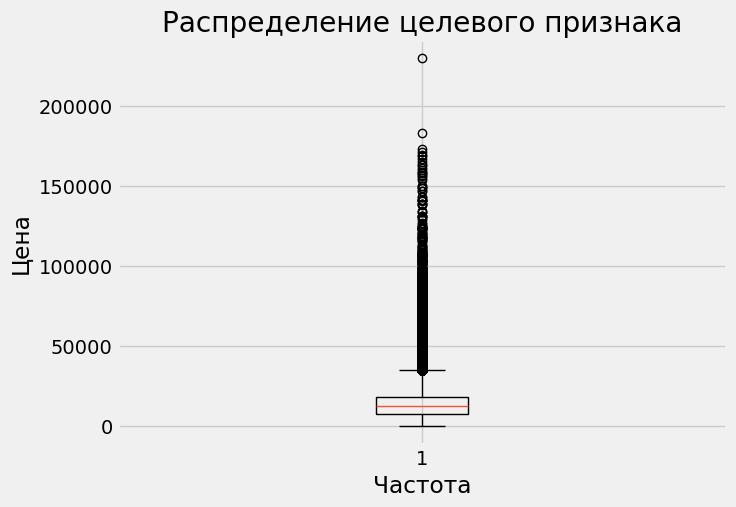

In [61]:
plt.figure(figsize=(7,5))
plt.boxplot(data['sellingprice']);
plt.title ('Распределение целевого признака');
plt.xlabel ('Частота');
plt.ylabel ('Цена');

In [62]:
data['sellingprice'].describe()

count    420273.000000
mean      13841.499192
std        9666.580449
min           1.000000
25%        7300.000000
50%       12400.000000
75%       18400.000000
max      230000.000000
Name: sellingprice, dtype: float64

In [63]:
data['sellingprice'].value_counts()

11000    3432
12000    3406
13000    3300
10000    3090
14000    3042
         ... 
37825       1
20950       1
18575       1
25601       1
2725        1
Name: sellingprice, Length: 1705, dtype: int64

Мы видим, что в среднем автомобили продаются за 13592 ед.
Разброс цен довольно большой, как указывает стандартное отклонение в размере 9751 ед.
Минимальная цена составляет всего 1 ед., что может указывать на наличие выбросов или ошибок в данных.
Медиана составляет 12100 ед., что означает, что половина наблюдений имеют цены ниже этого значения.
75% автомобилей имеют цены ниже 18,200 долларов.
Так как это наш целевой признак, вмешиваться в данные не будем и оставим все как есть.

**Посмотрим матрицу корреляции числовых признаков и выведем тепловую карту для наглядности.**

In [64]:
data.corr()

,year,condition,odometer,sellingprice
year,1.000000,0.549727,-0.777738,0.579767
condition,0.549727,1.000000,-0.537619,0.535760
odometer,-0.777738,-0.537619,1.000000,-0.577427
sellingprice,0.579767,0.535760,-0.577427,1.000000


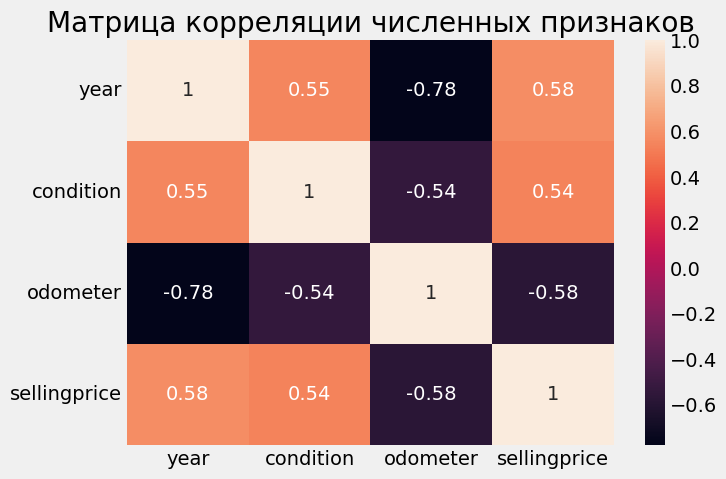

In [65]:
plt.figure(figsize=(7, 5))
plt.title('Матрица корреляции численных признаков')

sns.heatmap(data.corr(),annot = True)
plt.show()

Мы видим среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,78), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция (0,55) между состоянием авто и ценой, и между годом регистрации и ценой(0,58).

In [66]:
#!pip install -q phik
#import phik

#from phik.report import plot_correlation_matrix
#from phik import report

In [67]:
# построим таблицу корреляции смешанных признаков
#phik_overview = data.phik_matrix()
# округлим значения коэффициентов для удобства
#phik_overview.round(2)

 Библиотеку PHIK использовать не удалось, вероятно из-за размеров датасета и ограничений мощности jupyterHyb.

**Создадим новый признак - возраст авто.**

In [68]:
data['age'] = pd.to_datetime(data['saledate'], utc=True).dt.year - data['year']

In [69]:
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,4
1,2014,ford,Fusion,SE,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,1
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,3
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,12
4,2007,ford,Fusion,SEL,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,8


In [70]:
test['age'] = pd.to_datetime(test['saledate'], utc=True).dt.year - test['year']

**Создадим новый признак - пробег в год**

In [71]:
data['run_per_year'] = data['odometer'] / data['age']

**Создадим новый признак - год продажи**

In [72]:
data['year_of_sale'] = pd.to_datetime(data['saledate'], utc=True).dt.year

In [73]:
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age,run_per_year,year_of_sale
0,2011,ford,Edge,SEL,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,4,27760.250,2015
1,2014,ford,Fusion,SE,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,1,31034.000,2015
2,2012,nissan,Sentra,2.0 SL,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,3,11873.000,2015
3,2003,hummer,H2,Base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,12,10941.750,2015
4,2007,ford,Fusion,SEL,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,8,15963.625,2015


In [74]:
test['year_of_sale'] = pd.to_datetime(test['saledate'], utc=True).dt.year

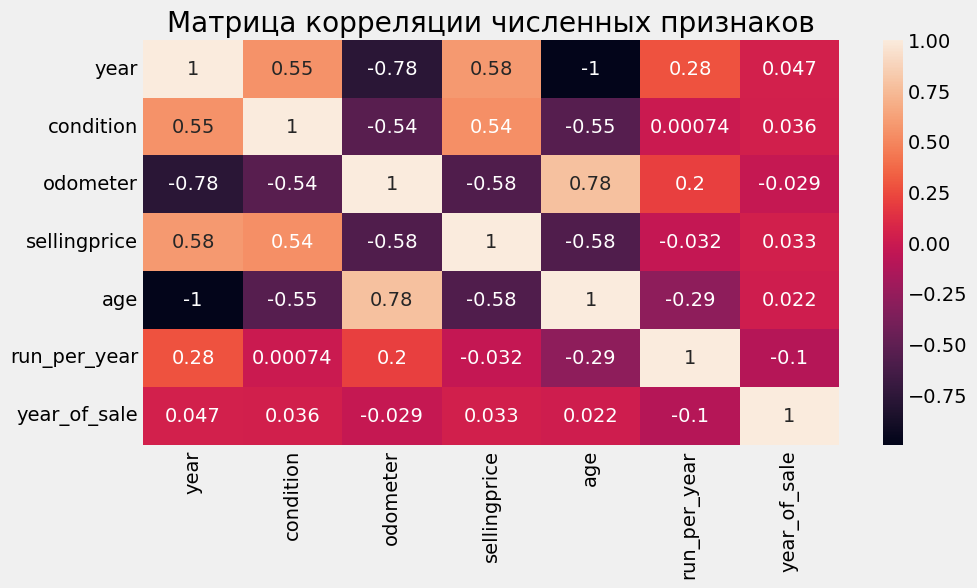

In [75]:
# рассмотрим еще раз тепловую карту после создания новых признаков
plt.figure(figsize=(10, 5))
plt.title('Матрица корреляции численных признаков')

sns.heatmap(data.corr(),annot = True)
plt.show()

Корреляция между годом продажи и ценой очень слабая (0,03), но пока оставим этот признак и посмотрим на метрику.
Корреляция между пробегом в год отрицательная и довольно слабая(-0.032), думаю стоит удалить данный признак и не использовать в модели.

In [76]:
data = data.drop(['run_per_year'], axis=1)

Рассмотрим наиболее интересные взаимосвязи наших категориальных признаков, с помощью визуализации и решим какие признаки оставить.

**Марка автомобиля ('make')**

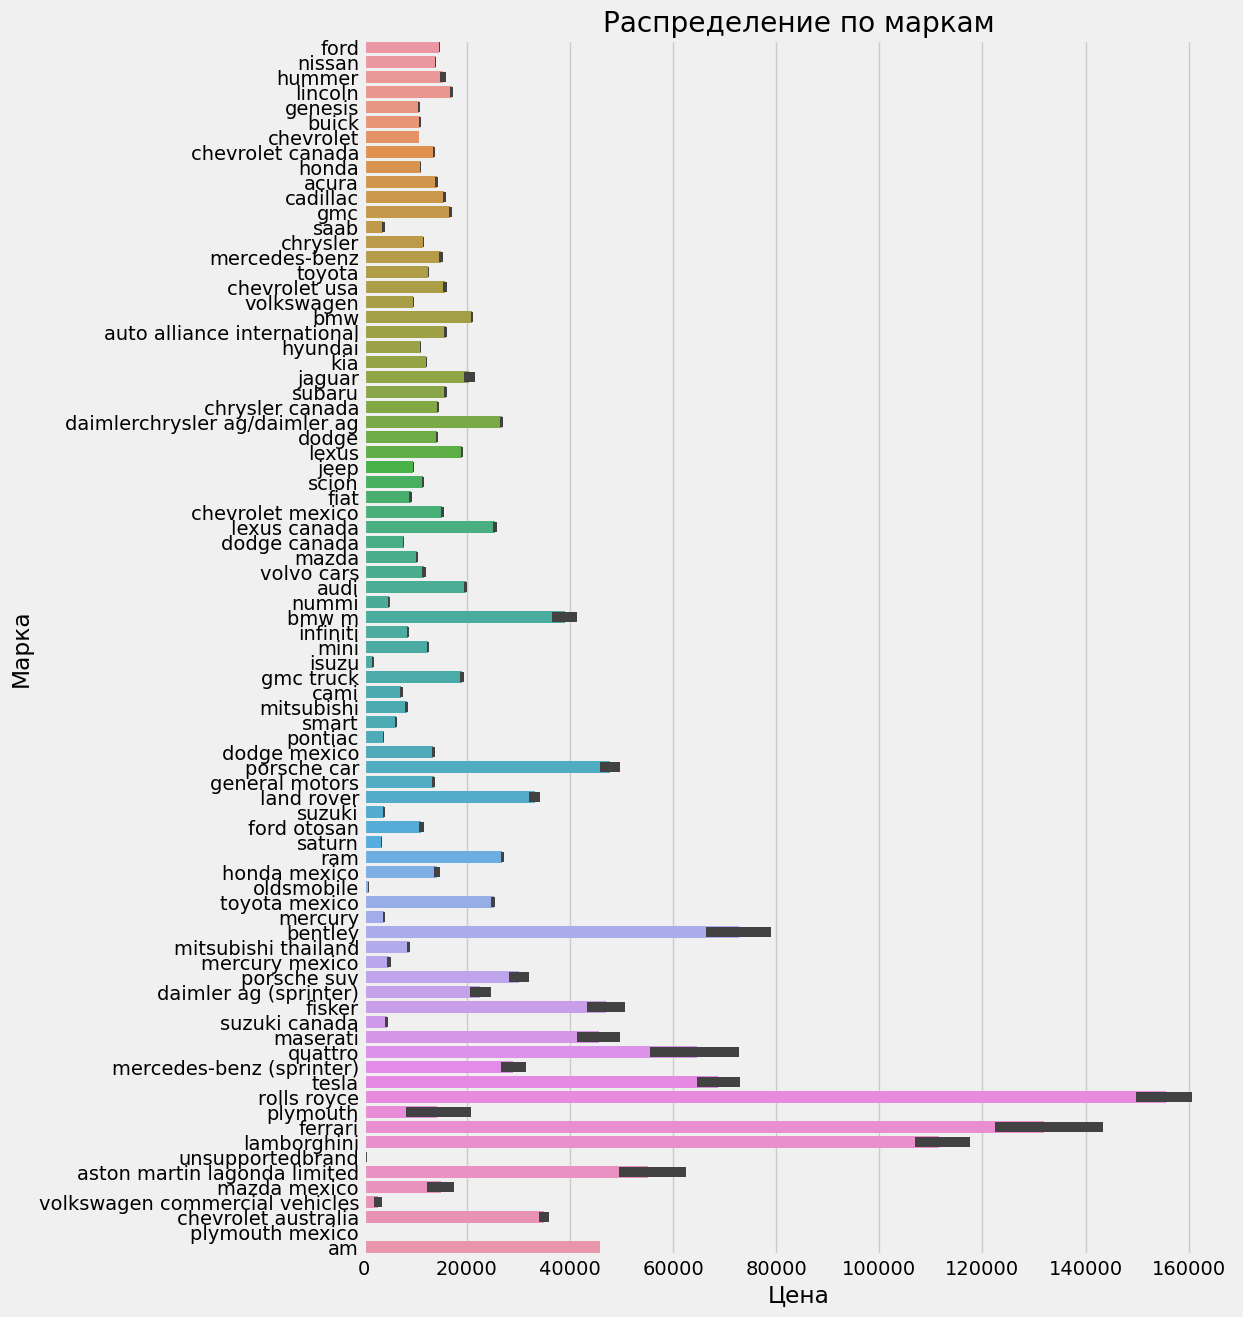

In [77]:
# построим барплот зависимости цены от марки авто
plt.figure(figsize=(10,15))

sns.barplot(x=data['sellingprice'],y=data['make']);
plt.title ('Распределение по маркам');
plt.xlabel ('Цена');
plt.ylabel ('Марка');
#plt.xticks(rotation = 45)
plt.show()

Здесь мы наглядно видим, что средние цены на автомобили люксового класса(rolls royce,ferrari,lamborgini) гораздо выше чем на автомобили среднего класса (ford,nissan,honda и др.).

Зависимость цены от модели и уровня отделки салона строить не будем, т.к. там слишком много разнообразных значений.

**Тип кузова ('body')**

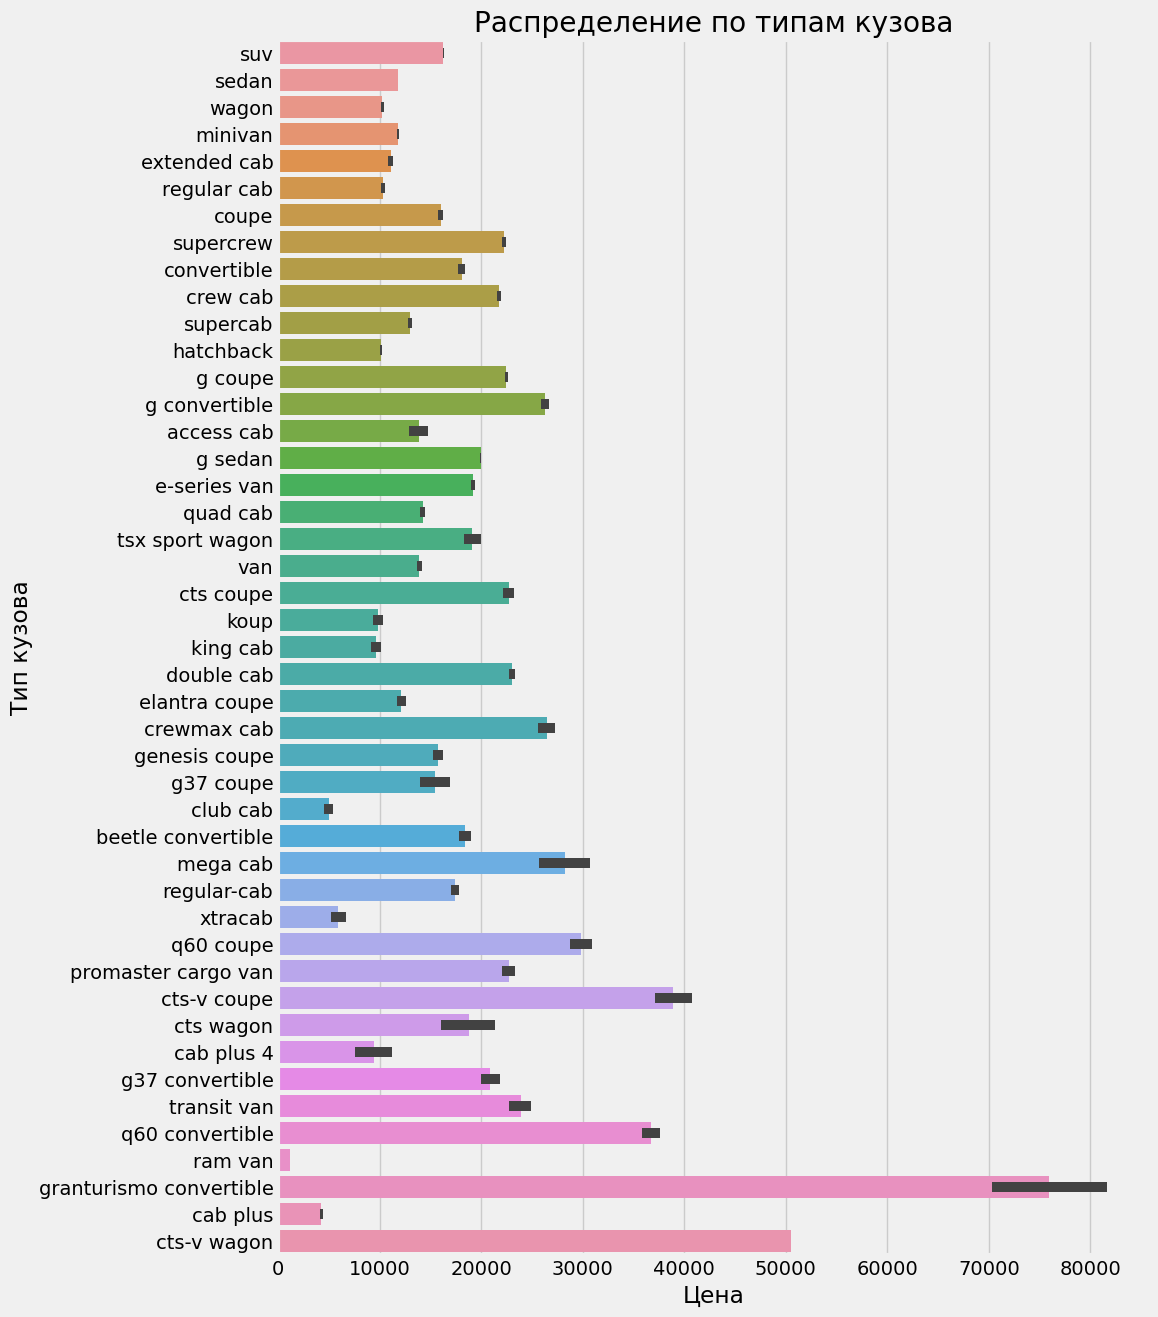

In [78]:
# построим барплот зависимости цены от типа кузова авто
plt.figure(figsize=(10,15))

sns.barplot(x=data['sellingprice'],y=data['body']);
plt.title ('Распределение по типам кузова');
plt.xlabel ('Цена');
plt.ylabel ('Тип кузова');
#plt.xticks(rotation = 45)
plt.show()

**Трансмиссия ('transmission')**

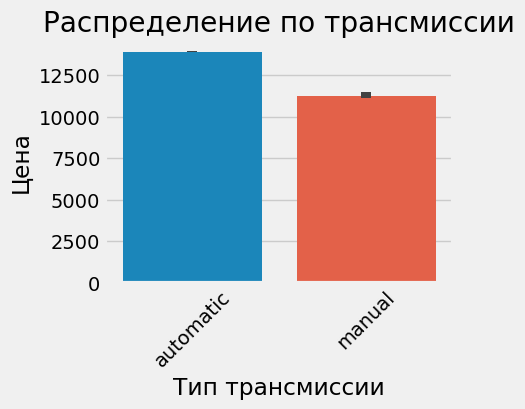

In [79]:
# построим барплот зависимости цены от типа трансмиссии авто
plt.figure(figsize=(4,3))

sns.barplot(x=data['transmission'],y=data['sellingprice']);
plt.title ('Распределение по трансмиссии');
plt.xlabel ('Тип трансмиссии');
plt.ylabel ('Цена');
plt.xticks(rotation = 45)
plt.show()

Естественно машины с автоматической коробкой передач в среднем стоят дороже механики.

**Состояние авто ('condition')**

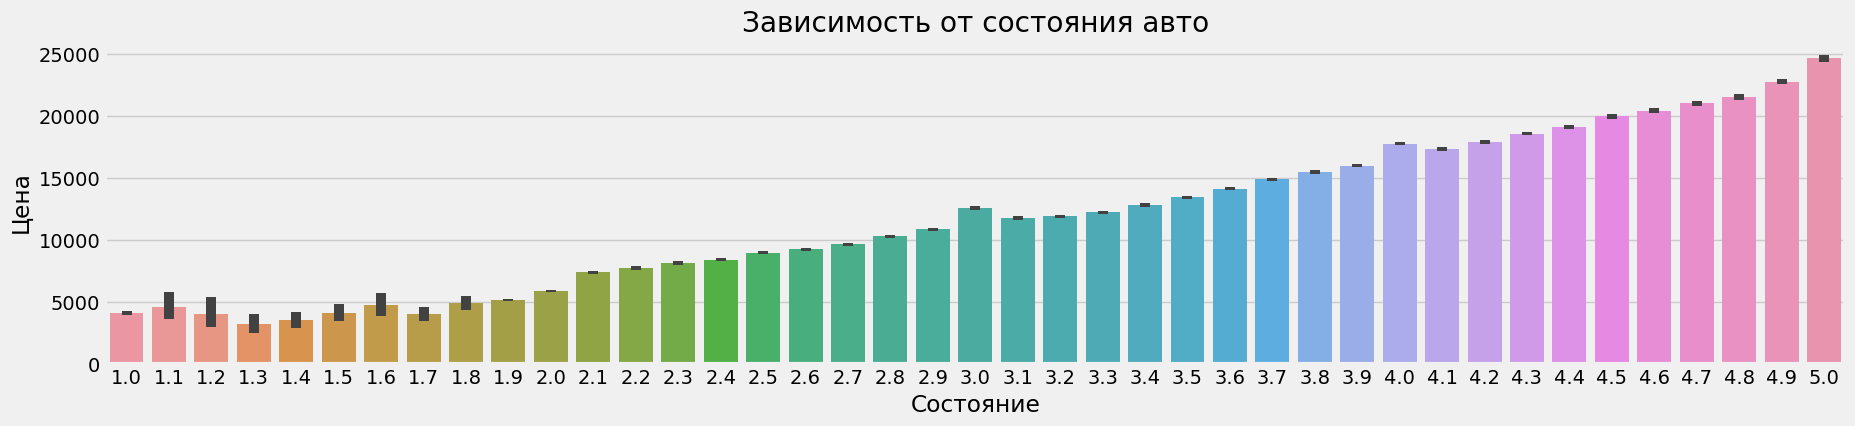

In [80]:
# построим барплот зависимости цены от состояния авто
plt.figure(figsize=(20,4))

sns.barplot(x=data['condition'],y=data['sellingprice']);
plt.title ('Зависимость от состояния авто');
plt.xlabel ('Состояние');
plt.ylabel ('Цена');
plt.show()

Здесь ярко выраженная зависимость - чем больше оценка состояния авто, тем выше цена.

**Цвет кузова ('color')**

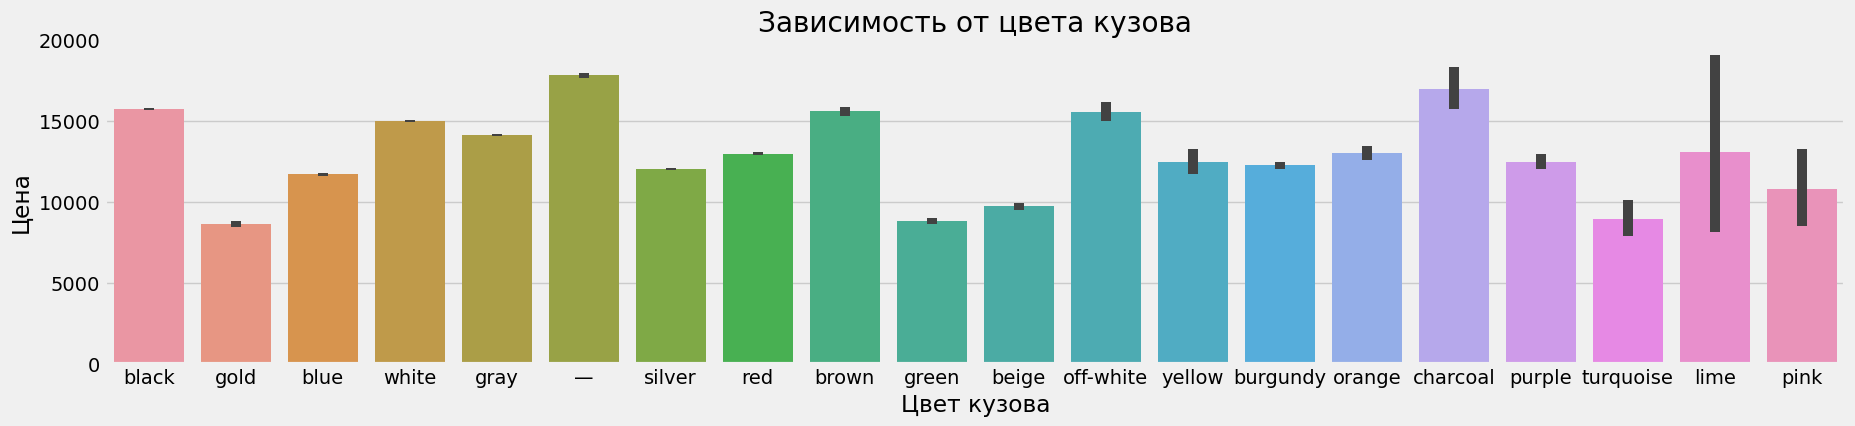

In [81]:
# построим барплот зависимости цены от цвета кузова
plt.figure(figsize=(20,4))

sns.barplot(x=data['color'],y=data['sellingprice']);
plt.title ('Зависимость от цвета кузова');
plt.xlabel ('Цвет кузова');
plt.ylabel ('Цена');
plt.show()

Дороже всего машины с цветом у которого стоит '-'. далее идут цвет 'charcoal' и затем черные авто. Дешевле всего машины золотого, зеленого и бирюзового цвета.

**Цвет салона ('interior')**

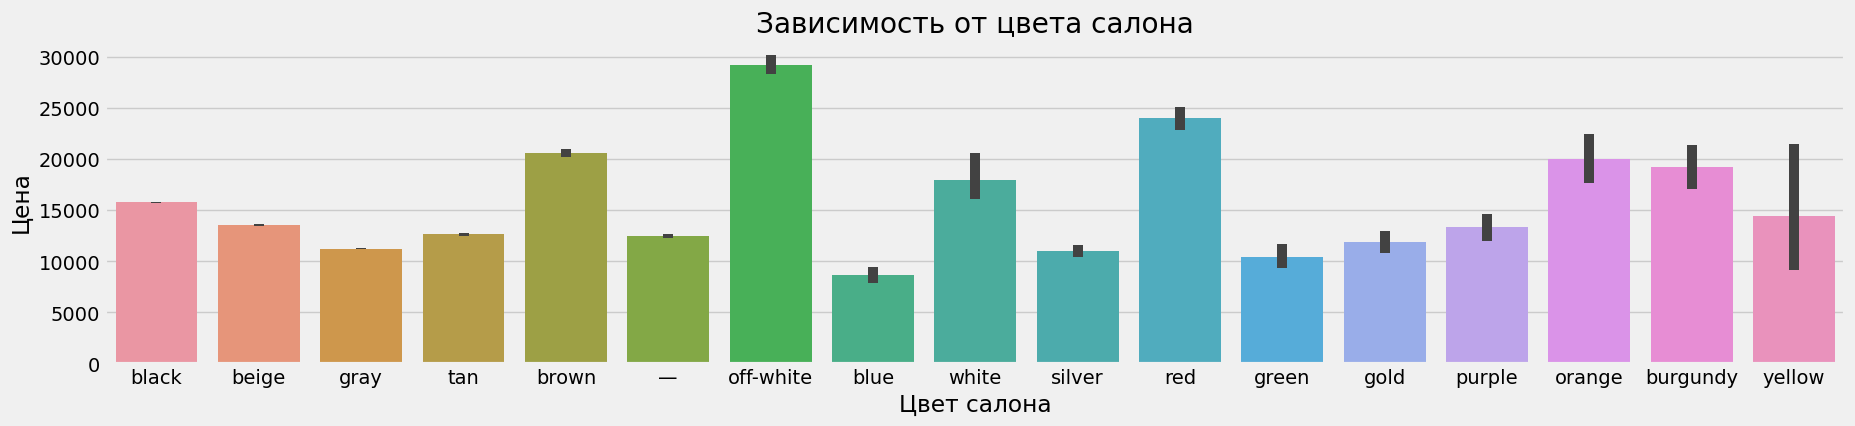

In [82]:
# построим барплот зависимости цены от цвета салона
plt.figure(figsize=(20,4))

sns.barplot(x=data['interior'],y=data['sellingprice']);
plt.title ('Зависимость от цвета салона');
plt.xlabel ('Цвет салона');
plt.ylabel ('Цена');
plt.show()

Здесь самые дорогие это с цветом 'off-white', затем с красной отделкой. Самые дешевые в голубой отделке.

**Год выпуска ('year')**

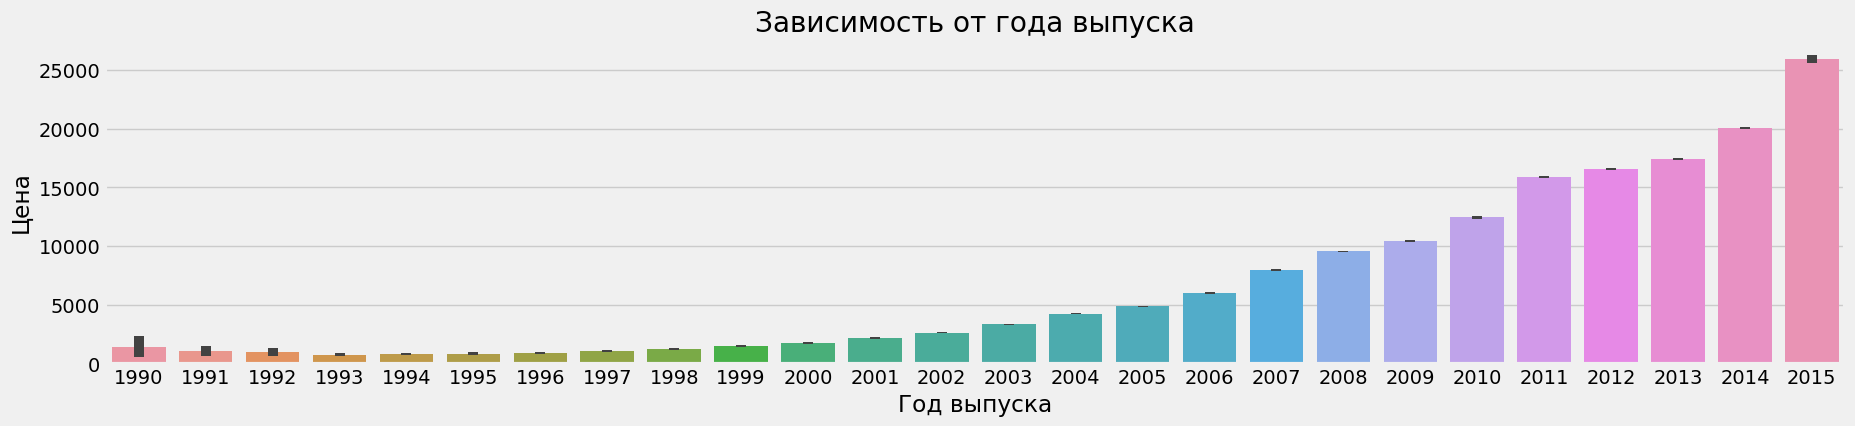

In [83]:
# построим барплот зависимости цены от года выпуска авто
plt.figure(figsize=(20,4))

sns.barplot(x=data['year'],y=data['sellingprice']);
plt.title ('Зависимость от года выпуска');
plt.xlabel ('Год выпуска');
plt.ylabel ('Цена');
plt.show()

Все логично, новые машины продаются по более высокой цене, в отличие от своих предшественников по году выпуска.

**Возраст ('age')**

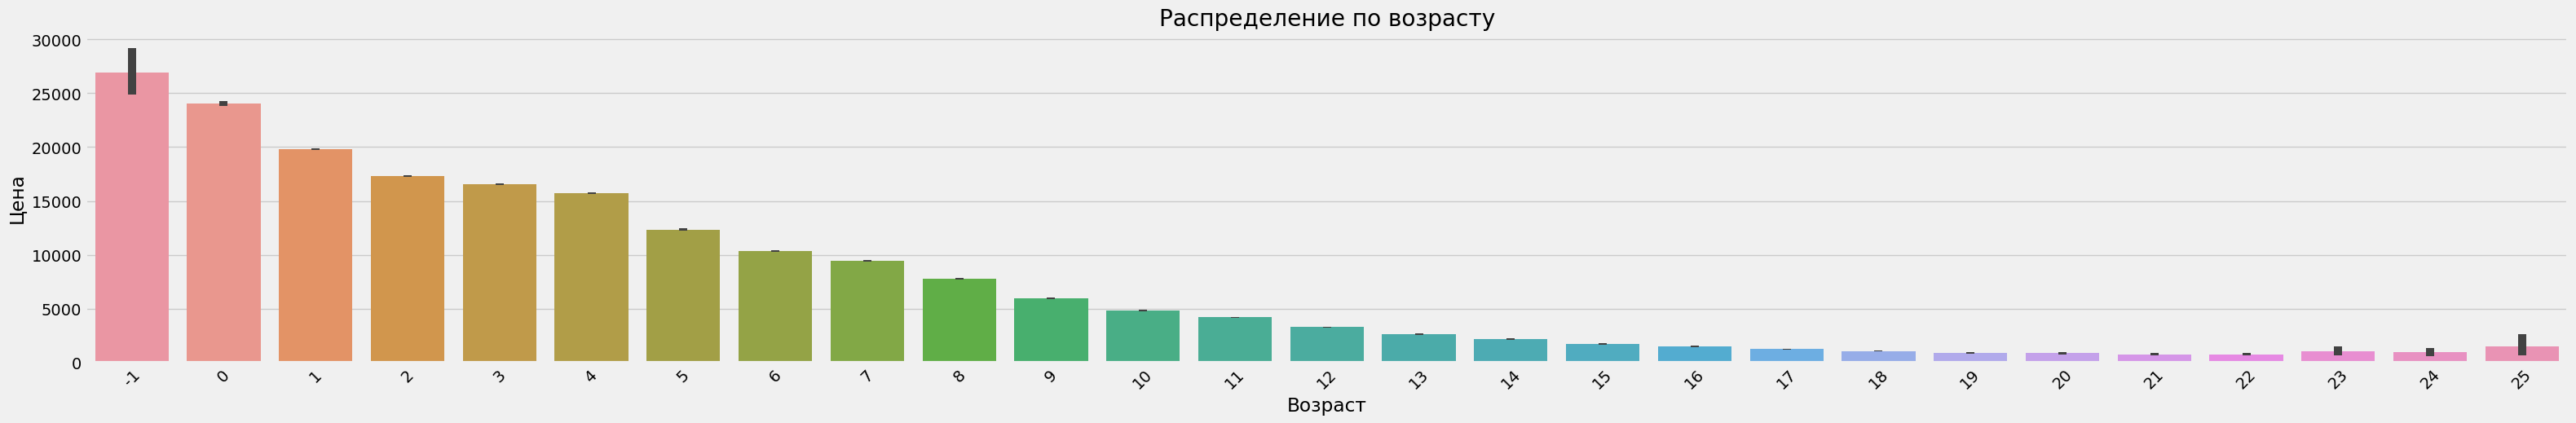

In [84]:
# построим барплот зависимости цены от возраста авто
plt.figure(figsize=(35,5))

sns.barplot(x=data['age'],y=data['sellingprice']);
plt.title ('Распределение по возрасту');
plt.xlabel ('Возраст');
plt.ylabel ('Цена');
plt.xticks(rotation = 45)
plt.show()

In [85]:
data.groupby(['age'])['sellingprice'].count()


age
-1       141
 0     10909
 1     64521
 2     77596
 3     77368
 4     35479
 5     19424
 6     16119
 7     23428
 8     21629
 9     18303
 10    14551
 11    11738
 12     9121
 13     6724
 14     4540
 15     3014
 16     1983
 17     1328
 18      901
 19      517
 20      421
 21      246
 22      124
 23       77
 24       44
 25       27
Name: sellingprice, dtype: int64

Здесь мы видим, что 141 машины были выпущены в 2015 г. по документам, а проданы в 2014 г. Следует уточнить эту информацию. Возможно стоит удалить эти строки?.

In [86]:
#data = data.drop(['saledate','transmission','year_of_sale'], axis=1)

In [87]:
#test = test.drop(['saledate','transmission','year_of_sale'], axis=1)

In [88]:
data = data.drop(['saledate','year_of_sale','transmission','color','state','interior'], axis=1)

In [89]:
test = test.drop(['saledate','year_of_sale','transmission','color','state','interior'], axis=1)

В рамках проведения экспериментов при обучении моделей выяснилось, что трансмиссия совершенно не влияет на метрику качества. Поэтоу принято решение удалить данный столбец. Также после визуализации важности признаков при обучении итоговой модели LGBMRegressor удалили столбцы 'color','state','interior'.

Объединим редко встречающиеся модели в категорию 'другие'

In [90]:
# Определите пороговое значение для объединения редких моделей
threshold = 10

# посчитаем количество вхождений каждой модели в столбце
model_counts = data['model'].value_counts()

# выберем модели, которые встречаются реже, чем пороговое значение
rare_models = model_counts[model_counts <= threshold].index

# заменим редкие значения в столбце на 'другие'
data['model'] = data['model'].replace(rare_models, 'другие')

In [91]:
# для тестовой выборки

# Посчитаем количество вхождений каждой модели в столбце
model_counts_test = test['model'].value_counts()

# выберем модели, которые встречаются реже, чем пороговое значение
rare_models_test = model_counts_test[model_counts_test <= threshold].index

# заменим редкие значения в столбце на 'другие'
test['model'] = test['model'].replace(rare_models_test, 'другие')

In [92]:
data.shape, test.shape

((420273, 10), (110058, 10))

**После проведения исследовательского анализа наших данных можно сделать следующие выводы:**

* в среднем автомобили продаются за 13592 ед. 
* из исходного датасета было удалено 2 неинформативных столбца: vin и saledate;
* из столбца saledate мы создали новый признак - год продажи авто;
* создали новый признак - возраст авто;
* попробовали создать новый признак - пробег за год, но при изучении тепловой карты корреляции решили удалить;
* обнаружили 141 авто 2015 г. проданных в 2014 г.;
* увидели среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,78), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция (0,55) между состоянием авто и ценой, и между годом регистрации и ценой(0,58).
* после обучения моделей также удалены столбы с трансмиссией, цветом кузова и салона и состоянием (state), в котором авто выставлен на аукцион.
* после изучения всех признаков мы получили обучающий датасет размером (420273, 10) и тестовый (110058, 10);

Данные готовы к обучению моделей.

## Выбор и обучение моделей

Разбивка на выборки

In [93]:
# введем константу
RANDOM_STATE = 12345

In [94]:
# cоздадим переменные для признаков и целевого признака
features = data.drop('sellingprice', axis=1)
target = data['sellingprice']

Далее разобьем данные на выборки. Разделим исходные данные на обучающую и валидационную выборки. Данные разобьем на 2 части, в соотношении 75:25.

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [97]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((315204, 9), (315204,), (105069, 9), (105069,))

### Обучение моделей

**Подотовим данные для обучения моделей линейной регрессии и случайного леса**

In [98]:
X_train_lr= X_train.copy()
X_valid_lr = X_valid.copy()

In [99]:
cat = X_train_lr.select_dtypes(include='object').columns.to_list()
num = X_train_lr.select_dtypes(exclude='object').columns.to_list()

In [100]:
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.compose import make_column_transformer

In [101]:
# кодируем категориальные признаки и масштабируем численные с помощью make_column_transformer

col_transformer_lr = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat),
        
    (StandardScaler(), 
      num
    ),remainder='passthrough',
    verbose_feature_names_out=False
)

In [102]:
X_train_lr  = pd.DataFrame(
    col_transformer_lr.fit_transform(X_train_lr),
    columns = col_transformer_lr.get_feature_names_out()
)
X_train_lr 

,make,model,trim,body,seller,year,condition,odometer,age
0,40.0,480.0,800.0,28.0,4852.0,-1.368246,-0.778248,1.459239,1.389727
1,74.0,135.0,971.0,36.0,9724.0,1.242646,1.652076,-1.262362,-1.223432
2,14.0,54.0,770.0,7.0,913.0,-0.323889,0.384081,-0.499567,0.344463
3,11.0,363.0,786.0,6.0,959.0,-1.107156,-1.623579,2.278527,0.867095
4,8.0,312.0,827.0,36.0,1093.0,0.720468,0.912412,-0.498323,-0.700800
...,...,...,...,...,...,...,...,...,...
315199,11.0,342.0,786.0,36.0,5544.0,0.720468,0.067082,-0.923899,-0.700800
315200,26.0,223.0,1040.0,36.0,8639.0,-0.323889,-1.306580,0.463060,0.344463
315201,20.0,513.0,273.0,42.0,4061.0,-1.107156,-1.095247,2.955891,1.128411
315202,74.0,396.0,1251.0,24.0,9391.0,0.720468,0.806746,-0.194350,-0.700800


In [103]:
# трансформируем валидационную выборку
X_valid_lr = pd.DataFrame(
    col_transformer_lr.transform(X_valid_lr),
    columns = col_transformer_lr.get_feature_names_out()
)

#смотрим на результат
X_valid_lr.head()

,make,model,trim,body,seller,year,condition,odometer,age
0,32.0,172.0,566.0,39.0,9142.0,-0.323889,0.067082,0.958210,0.344463
1,47.0,340.0,697.0,5.0,3138.0,0.459379,1.440743,-1.181337,-0.439484
2,26.0,209.0,1013.0,24.0,1093.0,0.981557,0.384081,-0.503129,-0.962116
3,27.0,541.0,475.0,28.0,4061.0,0.198289,-1.200914,0.926382,-0.178168
4,77.0,291.0,1179.0,43.0,1967.0,-0.062800,-0.672582,0.283411,0.083147


**Модель линейной регрессии LinearRegression**

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [105]:
# инициализируем модель линейной регрессии 
model_lr = LinearRegression()
# обучим 
model_lr.fit(X_train_lr, y_train)

LinearRegression()

In [106]:
# получим предсказания и рассчитаем метрику
pred_lr = model_lr.predict(X_valid_lr)

result_lr = mean_absolute_percentage_error(y_valid, pred_lr)

print(f'MAPE модели линейной регрессии на валидационной выборке: {result_lr}')

MAPE модели линейной регрессии на валидационной выборке: 0.6734568688088138


MAPE показал очень высокий показатель. Линейная регрессия дает плохой результат.

**Модель RandomForestRegressor**

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
# инициализируем модель RandomForestRegressor
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)

In [109]:
%%time
# обучим модель на тренировочной выборке
model_rfr.fit(X_train_lr, y_train)

CPU times: total: 3min 30s
Wall time: 3min 42s


RandomForestRegressor(random_state=12345)

In [110]:
# получим предсказания
pred_rfr = model_rfr.predict(X_valid_lr)

In [111]:
# посчитаем метрику MAPE
result_rfr = mean_absolute_percentage_error(y_valid, pred_rfr)
print(f'MAPE для RandomForestRegressor:{result_rfr}')


MAPE для RandomForestRegressor:0.17060469933068612


RandomForestRegressor дал неплохой результат. Рассмотрим еще бустинговые модели.

**Модель CatBoostRegressor (без подбора гиперпараметров и кросс-валидации)**

In [112]:
X_train_cb = X_train.copy()
X_valid_cb = X_valid.copy()

In [113]:
#численные признаки
num_cols = X_train_cb.select_dtypes(exclude='object').columns.to_list()
num_cols

['year', 'condition', 'odometer', 'age']

In [114]:
# создадим переменную с категориальными признаками для передачи в модель
cat_features = X_train_cb.select_dtypes(include='object').columns.to_list()
cat_features

['make', 'model', 'trim', 'body', 'seller']

In [115]:
from catboost import CatBoostRegressor, Pool

from sklearn.metrics import mean_absolute_percentage_error

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# инициализируем модель CatBoostRegressor
cb = CatBoostRegressor(loss_function='RMSE',
                       random_state=RANDOM_STATE,
                       verbose=False,
                       iterations=800,
                       custom_metric=['MAPE'])

train_pool = Pool(X_train_cb, y_train, cat_features=cat_features)

In [116]:
%%time
cb.fit(train_pool)

CPU times: total: 8min 45s
Wall time: 4min 23s


In [117]:
predictions = cb.predict(X_valid_cb)
mape_score = mape(y_valid, predictions)
print('MAPE:', mape_score)

MAPE: 0.16791601661803154


In [118]:
X_test = test.drop('vin', axis=1)

In [119]:
X_test.shape

(110058, 9)

In [120]:
num_cols_test = X_test.select_dtypes(exclude='object').columns.to_list()
num_cols_test

['year', 'condition', 'odometer', 'age']

In [121]:
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
cat_features_test

['make', 'model', 'trim', 'body', 'seller']

In [122]:
# создаем объект Pool для тестовых данных
test_pool = Pool(X_test, cat_features=cat_features_test)

In [123]:
cb_submission = pd.DataFrame()
cb_submission['vin'] = test['vin']
# делаем предсказания на тестовых данных
cb_submission['sellingprice'] = cb.predict(test_pool)

In [124]:
cb_submission['sellingprice'].head()

0     4659.336824
1    20599.622992
2    20504.259516
3     8649.379003
4    20928.124164
Name: sellingprice, dtype: float64

In [125]:
output = pd.DataFrame(cb_submission)
output.to_csv('submission.csv',index=False)

In [126]:
cb_submission.head()

,vin,sellingprice
0,1g6dp567450124779,4659.336824
1,1gtw7fca7e1902207,20599.622992
2,jn8az1mw6dw303497,20504.259516
3,2g1wf5e34d1160703,8649.379003
4,1n6aa0ec3dn301209,20928.124164


In [127]:
# сравним с образцом сабмита
sample_submission_ex = pd.read_csv('sample_submission.csv')
sample_submission_ex.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


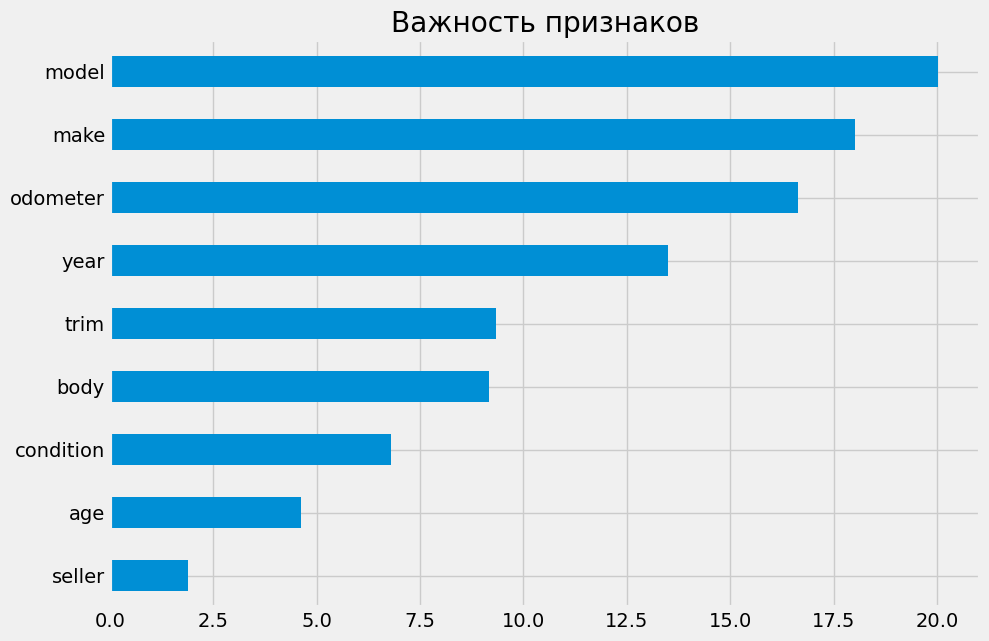

In [128]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (10,7))
importances = pd.Series(cb.feature_importances_,index=cb.feature_names_).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

В предыдущем эксперименте выяснилось, что трансмиссия и год продажи совершенно не влияют на модель CatBoostRegressor. Поэтому приняли решение их удалить из датасета.

**Модель CatBoostRegressor (c подбором гиперпараметров и кросс-валидацией)**

In [129]:
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

#pipeline_catboost = Pipeline([
    #('cb', CatBoostRegressor(loss_function='RMSE',
                             #random_state=RANDOM_STATE,
                             #cat_features=cat_features))
#])

#parameters_catboost = {
    #'cb__iterations': [800],
    #'cb__depth': [4,6,8],
    #'cb__learning_rate': [0.01,0.1,0.15]
#}

In [130]:
#gs_model_cb = GridSearchCV(
    #estimator=pipeline_catboost,
    #param_grid=parameters_catboost,
    #scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    #cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    #n_jobs=-1
#)

In [131]:
#%%time
#gs_model_cb.fit(X_train_cb, y_train)


In [132]:
#best_params = gs_model_cb.best_params_
#best_params

In [133]:
#best_model = gs_model_cb.best_estimator_
#best_model

In [134]:
#best_score = -gs_model_cb.best_score_
#print("Best Parameters:", best_params)
#print("MAPE:", best_score)

In [135]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

#plt.figure(figsize = (10,7))
#importances = pd.Series(best_model.named_steps['cb'].feature_importances_,index=best_model['cb'].feature_names_).sort_values()

# график
#importances.plot.barh(grid=True, title='Важность признаков');

**LGBMRegressor**

In [136]:
!pip install lightgbm
from lightgbm import LGBMRegressor

In [137]:
# обозначим категориальные столбцы для передачи в LGBMRegressor
cat_columns = X_train.select_dtypes(include='object').columns.to_list()
cat_columns 

data[cat_columns] = data[cat_columns].astype("category")

In [138]:
# cоздадим переменные для признаков и целевого признака

X = data.drop('sellingprice', axis=1)
y= data['sellingprice']

In [139]:
# обозначим категориальные столбцы теста для передачи в LGBMRegressor
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
test[cat_columns] = test[cat_features_test].astype("category")

In [140]:
X_test = test.drop('vin', axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   year       110058 non-null  int64   
 1   make       110058 non-null  category
 2   model      110058 non-null  category
 3   trim       110058 non-null  category
 4   body       110058 non-null  category
 5   condition  110058 non-null  float64 
 6   odometer   110058 non-null  float64 
 7   seller     110058 non-null  category
 8   age        110058 non-null  int64   
dtypes: category(5), float64(2), int64(2)
memory usage: 4.6 MB


In [141]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,y, test_size=0.25, random_state=RANDOM_STATE)


In [142]:
# выведем на экран размеры таблиц, которые хранятся в 4-х переменных
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((315204, 9), (315204,), (105069, 9), (105069,))

In [143]:
# инициализируем модель LGBMRegressor
#lgbm = LGBMRegressor(objective='RMSE',random_state=RANDOM_STATE)

In [144]:
#lgbm.fit(X_train, y_train)

In [145]:
#predictions_lgbm = lgbm.predict(X_valid)
#mape_score = mape(y_valid, predictions_lgbm)
#print('MAPE:', mape_score)

In [146]:
# построим гистограмму значимости признаков для модели LGBMRegressor
# значения отсортированные по возрастанию влияния

#plt.figure(figsize = (10,7))
#importances = pd.Series(lgbm.feature_importances_,index=X_train.columns).sort_values()

# график
#importances.plot.barh(grid=True, title='Важность признаков LGBMRegressor');

**LGBMRegressor** с подбором гиперпараметров и кросс-валидацией

In [147]:
pipeline_lightgbm = Pipeline([
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE,force_row_wise=True))
                          
])

parameters_lightgbm = {
    'lgbm__n_estimators': [700],
    'lgbm__max_depth': [4,12],
    'lgbm__learning_rate': [0.01,0.1,0.15],
    'lgbm__num_leaves': [12,24,36],
    'lgbm__reg_alpha': [0, 0.1, 0.5]
}

gs_model_lightgbm = GridSearchCV(
    estimator=pipeline_lightgbm,
    param_grid=parameters_lightgbm,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,error_score='raise'
)

In [148]:
gs_model_lightgbm.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Total Bins 5918
[LightGBM] [Info] Number of data points in the train set: 315204, number of used features: 9
[LightGBM] [Info] Start training from score 13846.779692


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('lgbm',
                                        LGBMRegressor(force_row_wise=True,
                                                      random_state=12345))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.01, 0.1, 0.15],
                         'lgbm__max_depth': [4, 12],
                         'lgbm__n_estimators': [700],
                         'lgbm__num_leaves': [12, 24, 36],
                         'lgbm__reg_alpha': [0, 0.1, 0.5]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [149]:
best_params_lightgbm = gs_model_lightgbm.best_params_
best_params_lightgbm

{'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': 12,
 'lgbm__n_estimators': 700,
 'lgbm__num_leaves': 36,
 'lgbm__reg_alpha': 0.1}

In [150]:
best_model_lightgbm = gs_model_lightgbm.best_estimator_
best_model_lightgbm

Pipeline(steps=[('lgbm',
                 LGBMRegressor(force_row_wise=True, max_depth=12,
                               n_estimators=700, num_leaves=36,
                               random_state=12345, reg_alpha=0.1))])

In [151]:
best_score_lightgbm = -gs_model_lightgbm.best_score_
print("Best Parameters:", best_params_lightgbm)
print("MAPE:", best_score_lightgbm)

Best Parameters: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 700, 'lgbm__num_leaves': 36, 'lgbm__reg_alpha': 0.1}
MAPE: 0.14089271011790733


### Тестирование лучшей модели на тестовой выборке и получение предсказаний для submit на Kaggle

In [153]:
best_submission_lightgbm  = pd.DataFrame()
best_submission_lightgbm ['vin'] = test['vin']
# делаем предсказания на тестовых данных
best_submission_lightgbm ['sellingprice'] = best_model_lightgbm.predict(X_test)

In [154]:
output = pd.DataFrame(best_submission_lightgbm)
output.to_csv('submission.csv',index=False)

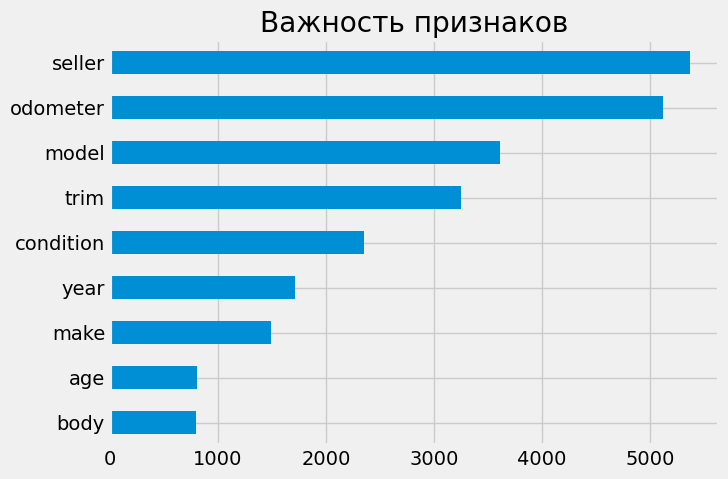

In [155]:
# построим гистограмму значимости признаков для модели CatBoost
# значения отсортированные по возрастанию влияния

plt.figure(figsize = (7,5))
importances = pd.Series(best_model_lightgbm.named_steps['lgbm'].feature_importances_,index=X_train.columns).sort_values()

# график
importances.plot.barh(grid=True, title='Важность признаков');

**Проверим модель на адекватность**

In [156]:
from sklearn.dummy import DummyRegressor

In [157]:
dummy_model = DummyRegressor(strategy="mean")


dummy_model.fit(X_train, y_train)


dummy_predictions = dummy_model.predict(X_valid)
dummy_model_mape = mean_absolute_percentage_error(y_valid, dummy_predictions)

print(f'DummyRegressor:{dummy_model_mape}')

DummyRegressor:1.7053867208880389


Mетрика MAPE у дамми модели гораздо выше, чем на всех наших моделях на тестовой выборке. Это говорит нам о том, что наши модели достаточно адекватны.

## Общий вывод
### Вывод

Мы провели работу по подготовке прототипа модели машинного обучения. Данная работа принимала участиие в соревновании на платформе Kaggle.

**Цель проекта** - прогнозирование стоимости автомобилей на вторичном рынке.

**Наша задача** - создание прототипа модели машинного обучения, который позволит позволит компаниям разрабатывать собственное приложение, чтобы привлечь новых клиентов для оценки стоимости их авто для продажи. 

Для оценки качества моделей была использована метрика MAPE (Mean Absolute Percentage Error),которая измеряет отклонение прогнозных значений от фактических значений в процентном соотношении.

В нашем распоряжении были исторические данные о технических характеристиках,марках,моделях, комплектации, состоянии и ценах других автомобилей. Данные находились в 2-х файлах (обучающая и тестовые датасеты). В ходе работы был проведен обзор первоначальных данных и их предобработка. Найденные пропуски были заполнены значениями "other". Дубликаты удалены. Неинформативные столбцы были удалены, т.к. не представляют важности при обучении модели. Аномалии в данных обработаны.

Работа была проведена в соответствии с первононачальным планом. 

Была проведена загрузка исходных данных, их обзор и предобработка:

1. Изменены типы данных в столбце 'saledate'. В результате выяснили, что данные представлены за период c 2014-01-01 01:15:00+00:00 по 2015-07-20 19:30:00+00:00. В тесте c 2014-01-01 01:15:00+00:00 по 2015-07-13 23:30:00+00:00. Машины продавались с понедельника по субботу включительно.
2. Удалось заполнить пропущенные значения в столбце 'make', получив информацию из vin кода.
3. Пропуски в столбце 'transmission' заполнили на основе группировки по году, марке, модели авто и получению методом idmax наиболее вероятного значения. Оставшиеся 0,4 % пропусков были удалены из трейна. В тесте заменены на значение 'no'.
4. Незначительные пропуски (около 2%) в столбцах 'model','trim','body','transmission','odometer','condition','color','interior' были удалены в трейне, в тесте заменены на значение 'no'.
5. Поработали с неявными дубликатами в столбцах 'make'и'body'. Путем приведения к нижнему регистру удалось снизить количество дубликатов только в столбце 'body'.
6. Посмотрели столбец с пробегом, выявили 49 строк с аномально большим пробегом, оставили без изменений.
7. Столбец 'vin' удалили из трейна т.к. он для нас не важен. В тесте оставили.
8. После изучения всех признаков мы получили обучающий датасет размером (420273, 14) и тестовый (110058, 14));

Далее мы провели глубокий исследовательский анализ данных и визуализировали с помощью графиков результаты зависимости наших признаков и таргета:

* в среднем автомобили продаются за 13592 ед. 
* из исходного датасета было удалено 2 неинформативных столбца: vin и saledate;
* из столбца saledate мы создали новый признак - год продажи авто;
* создали новый признак - возраст авто;
* попробовали создать новый признак - пробег за год, но при изучении тепловой карты корреляции решили удалить;
* обнаружили 141 авто 2015 г. проданных в 2014 г.;
* увидели среднюю корреляцию между числовыми данными и нашим таргетом. Наибольший интерес заслуживает наличие отрицательной взаимосвязи между пробегом и стоимостью при продаже (-0,78), что логично, ведь чем больше пробег у авто, тем ниже ее цена. Также есть корреляция (0,55) между состоянием авто и ценой, и между годом регистрации и ценой(0,58).
* после обучения моделей также удалены столбы с трансмиссией, цветом кузова и салона и состоянием (state), в котором авто выставлен на аукцион.
* после изучения всех признаков мы получили обучающий датасет размером (420273, 10) и тестовый (110058, 10);

Следующим шагом была проведена разбивка данных на обучающий и валидационный набор, с размером валидационной выборки 0.25. Был введен параметр RANDOM_STATE = 12345. Были выделены признаки и целевой признак.

**Так для обучения модели были использованы следующие 9 признаков:**

категориальные:'make', 'model', 'trim', 'body', 'seller'
численные 'year', 'condition', 'odometer', 'age'.

Признаки: 'saledate','year_of_sale','transmission','color','state','interior' были удалены после первичного обучения моделей CatBoostRegressor и LGBMRegressor. Мы изучили важность этих признаков при обучении моделей и увидели, что их доля очень маленькая.

Далее мы провели обучение моделей машинного обучения, для выполнения поставленной цели. Ключевой метрикой моделей была использована метрика MAPE (Mean Absolute Percentage Error),которая измеряет отклонение прогнозных значений от фактических значений в процентном соотношении.


Нами было инициализировано 4 модели: LinearRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Для подбора гиперпараметров в целях улучшения качества моделей, а также для проведения проверки качества был использован GridSearchCV.

Для моделей LinearRegression, RandomForestRegressor было проведено кодирование категориальных признаков методом OrdinalEncoder (для линейных моделей следовало бы использовать при кодировке OneHotEncoder, но для данного датасета не хватило мощности для обработки) и масштабирование численных признаков методом стандартизации StandardScaler.

Метрика MAPE для модели LinearRegression показала очень слабый результат (0,6734). Для RandomForestRegressor составила 0,1706.

Наилучшие результаты были достигнуты при ипользовании бустинговых моделей.
Выбрав лучшую модель LGBMRegressor, которая достигла самого низкого значения MAPE на кросс-валидации,мы получили с помощью нее предсказания для нашей тестовой выборки и отправили на 'submit'. Также была проведена проверка на адекватность лучшей модели в сравнении с константной моделью.

Также мы рассмотрели наиболее значимые признаки, которые позволили достигнуть нашей метрики. Можем выделить следующие наиболее **важные признаки при обучении модели**,в порядке важности:

* seller   
* odometer   
* model    
* trim    
* condition
* year 
* make
* age 
* body

Лучшей моделью машинного обучения в нашем случае выбрана модель LGBMRegressor, показав лучшее значение на тестовых данных значение 15,99 (на обучающей 14,08).

**Гиперпараметры итоговой лучшей модели:**

**LGBMRegressor

(random_state=RANDOM_STATE,
'lgbm__learning_rate': 0.1, 
'lgbm__max_depth': 12, 
'lgbm__n_estimators': 700, 
'lgbm__num_leaves': 36, 
'lgbm__reg_alpha': 0.1)**

